In [1]:
import os, sys
import networkx as nx

os.chdir('..')
sys.path.append("../embed")
from embed import embed

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.cluster import KMeans
from sklearn import metrics

from time import time
from tqdm import tqdm

train_dir = '/dfs/scratch0/manans/nf-exp/train'
train_labels = {}
test_dir  = '/dfs/scratch0/manans/nf-exp/test'
emb_dir   = '/dfs/scratch0/manans/nf-exp/emb'

In [33]:
import random
def add_and_remove_edges(G, p_new_connection, p_remove_connection):    
    '''    
    for each node,    
      add a new connection to random other node, with prob p_new_connection,    
      remove a connection, with prob p_remove_connection    

    operates on G in-place    
    '''                
    new_edges = []    
    rem_edges = []    

    for node in G.nodes():    
        # find the other nodes this one is connected to    
        connected = [to for (fr, to) in G.edges(node)]    
        # and find the remainder of nodes, which are candidates for new edges   
        unconnected = [n for n in G.nodes() if not n in connected]    

        # probabilistically add a random edge    
        if len(unconnected): # only try if new edge is possible    
            if random.random() < p_new_connection:    
                new = random.choice(unconnected)    
                G.add_edge(node, new)    
                #print "\tnew edge:\t {} -- {}".format(node, new)    
                new_edges.append( (node, new) )    
                # book-keeping, in case both add and remove done in same cycle  
                unconnected.remove(new)    
                connected.append(new)    

        # probabilistically remove a random edge    
        if len(connected): # only try if an edge exists to remove    
            if random.random() < p_remove_connection:    
                remove = random.choice(connected)    
                G.remove_edge(node, remove)    
                #print "\tedge removed:\t {} -- {}".format(node, remove)    
                rem_edges.append( (node, remove) )    
                # book-keeping, in case lists are important later?    
                connected.remove(remove)    
                unconnected.append(remove)    
    return rem_edges, new_edges    

def save_graph(G, name, directory):
    nx.write_edgelist(G, directory + "/" + name)
    
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    fig = plt.figure()
    for i in range(X.shape[0]):
        if y[i] == 0:
            clr = 'b'
        elif y[i] == 1:
            clr = 'r'
        point = plt.plot(X[i, 0], X[i, 1], color=clr, marker='o')

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

def evaluate(embeddings, labels):
    estimator  = KMeans(n_clusters = 2).fit(embeddings)
    AMI = metrics.adjusted_mutual_info_score(labels,  estimator.labels_)
    ARI = metrics.adjusted_rand_score(labels, estimator.labels_)
    return AMI, ARI

## Stage 1 (Identical Cycle / Different BA)

In [10]:
circle_graphs = []
G = nx.cycle_graph(50)
for i in tqdm(xrange(500)):
    save_graph(G, str(i) + '.edgelist', train_dir if i < 400 else test_dir)
    if i < 400:
        train_labels[str(i) + '.edgelist'] = 0
    circle_graphs.append(G)
    
ba_graphs = []
for i in tqdm(xrange(500)):
    G = nx.barabasi_albert_graph(50, 5)
    save_graph(G, str(i + 500) + '.edgelist', train_dir if (i + 500) < 900 else test_dir)
    if (i + 500) < 900:
        train_labels[str(i + 500) + '.edgelist'] = 1
    ba_graphs.append(G)

100%|██████████| 500/500 [00:16<00:00, 30.96it/s]


In [11]:
s1_emb = \
    embed(train_input_directory     = train_dir,
            train_label_mapping     = train_labels,
            test_input_directory    = test_dir,
            test_output_directory   = emb_dir,
            method                  = 'nf-original',
            n_epochs                = 2,
            train                   = True)

Loading data...
Regression on 560 training points.
--------------------------------------------------------------------------------
Mean predictor

Performance (RMSE) on label:
Train: 0.499971300197
Test:  0.499894759333
--------------------------------------------------------------------------------
Task params {'learn_rate': 0.00012340980408667956, 'fp_depth': 3, 'b1': 0.018315638888734179, 'b2': 0.018315638888734179, 'init_scale': 0.018315638888734179, 'fp_length': 50, 'l2_penalty': 0.018315638888734179, 'l1_penalty': 0.006737946999085467, 'conv_width': 10}
Total number of weights in the network: 11701
N_ITER 2
Iteration 0 loss 3.68668922424 train RMSE 0.959964302306 Validation RMSE 0 : 0.961395804213 
	 Learning rate is constant => 0.000123409804087
Iteration 1 loss 3.06915335068 train RMSE 0.87587970648 Validation RMSE 1 : 0.876609919686 
	 Learning rate is constant => 0.000123409804087

Performance (RMSE) on label:

100%|██████████| 200/200 [00:19<00:00, 10.07it/s]


Train: 0.794171760252
Test:  0.794196848896
--------------------------------------------------------------------------------


In [34]:
X = np.array([])
y = []

for i, key in enumerate(s1_emb.keys()):
    if i == 0:
        X = np.hstack((X, s1_emb[key]))
    else:
        X = np.vstack((X, s1_emb[key]))
    y.append(0 if int(key) < 500 else 1)

print evaluate(X, y)

(1.0, 1.0)


## Stage 2 (Different Cycle / Different BA)

In [63]:
circle_graphs = []
for i in tqdm(xrange(500)):
    G = nx.cycle_graph(np.random.randint(30, 100))
    save_graph(G, str(i) + '.edgelist', train_dir if i < 400 else test_dir)
    if i < 400:
        train_labels[str(i) + '.edgelist'] = 0
    circle_graphs.append(G)
    
ba_graphs = []
for i in tqdm(xrange(500)):
    G = nx.barabasi_albert_graph(50, 5)
    save_graph(G, str(i + 500) + '.edgelist', train_dir if (i + 500) < 900 else test_dir)
    if (i + 500) < 900:
        train_labels[str(i + 500) + '.edgelist'] = 1
    ba_graphs.append(G)

100%|██████████| 500/500 [00:17<00:00, 28.32it/s]


In [64]:
s2_emb = \
    embed(train_input_directory     = train_dir,
            train_label_mapping     = train_labels,
            test_input_directory    = test_dir,
            test_output_directory   = emb_dir,
            method                  = 'nf-original',
            n_epochs                = 2,
            train                   = True)

Loading data...
Regression on 560 training points.
--------------------------------------------------------------------------------
Mean predictor

Performance (RMSE) on label:
Train: 0.499971300197
Test:  0.499894759333
--------------------------------------------------------------------------------
Task params {'learn_rate': 0.00012340980408667956, 'fp_depth': 3, 'b1': 0.018315638888734179, 'b2': 0.018315638888734179, 'init_scale': 0.018315638888734179, 'fp_length': 50, 'l2_penalty': 0.018315638888734179, 'l1_penalty': 0.006737946999085467, 'conv_width': 10}
Total number of weights in the network: 11701
N_ITER 2
Iteration 0 loss 4.0706478369 train RMSE 1.0087170543 Validation RMSE 0 : 1.01970740255 
	 Learning rate is constant => 0.000123409804087
Iteration 1 loss 3.40637302716 train RMSE 0.92274617392 Validation RMSE 1 : 0.932717523267 
	 Learning rate is constant => 0.000123409804087

Performance (RMSE) on label:

100%|██████████| 200/200 [00:20<00:00,  9.84it/s]


Train: 0.839048257107
Test:  0.847977112451
--------------------------------------------------------------------------------


In [65]:
X = np.array([])
y = []

for i, key in enumerate(s2_emb.keys()):
    if i == 0:
        X = np.hstack((X, s2_emb[key]))
    else:
        X = np.vstack((X, s2_emb[key]))
    y.append(0 if int(key) < 500 else 1)

print evaluate(X, y)

(1.0, 1.0)


## Stage 3 (10% Cross Links)

In [66]:
p_new_connection = 0.1

circle_graphs = []
for i in tqdm(xrange(500)):
    G = nx.cycle_graph(np.random.randint(30, 100))
    add_and_remove_edges(G, p_new_connection, 0)
    save_graph(G, str(i) + '.edgelist', train_dir if i < 400 else test_dir)
    if i < 400:
        train_labels[str(i) + '.edgelist'] = 0
    circle_graphs.append(G)
    
ba_graphs = []
for i in tqdm(xrange(500)):
    G = nx.barabasi_albert_graph(50, 5)
    save_graph(G, str(i + 500) + '.edgelist', train_dir if (i + 500) < 900 else test_dir)
    if (i + 500) < 900:
        train_labels[str(i + 500) + '.edgelist'] = 1
    ba_graphs.append(G)

100%|██████████| 500/500 [00:16<00:00, 29.44it/s]


In [67]:
s3_emb = \
    embed(train_input_directory     = train_dir,
            train_label_mapping     = train_labels,
            test_input_directory    = test_dir,
            test_output_directory   = emb_dir,
            method                  = 'nf-original',
            n_epochs                = 2,
            train                   = True)

Loading data...
Regression on 560 training points.
--------------------------------------------------------------------------------
Mean predictor

Performance (RMSE) on label:
Train: 0.499971300197
Test:  0.499894759333
--------------------------------------------------------------------------------
Task params {'learn_rate': 0.00012340980408667956, 'fp_depth': 3, 'b1': 0.018315638888734179, 'b2': 0.018315638888734179, 'init_scale': 0.018315638888734179, 'fp_length': 50, 'l2_penalty': 0.018315638888734179, 'l1_penalty': 0.006737946999085467, 'conv_width': 10}
Total number of weights in the network: 11701
N_ITER 2
Iteration 0 loss 4.2474016035 train RMSE 1.03038510502 Validation RMSE 0 : 1.042208581 
	 Learning rate is constant => 0.000123409804087
Iteration 1 loss 3.56175622592 train RMSE 0.943558075496 Validation RMSE 1 : 0.954259963376 
	 Learning rate is constant => 0.000123409804087

Performance (RMSE) on label:

100%|██████████| 200/200 [00:20<00:00,  9.97it/s]


Train: 0.858942078513
Test:  0.868497058291
--------------------------------------------------------------------------------


In [68]:
X = np.array([])
y = []

for i, key in enumerate(s3_emb.keys()):
    if i == 0:
        X = np.hstack((X, s3_emb[key]))
    else:
        X = np.vstack((X, s3_emb[key]))
    y.append(0 if int(key) < 500 else 1)

print evaluate(X, y)

(1.0, 1.0)


## Stage 4 (30% Cross Links)

In [69]:
p_new_connection = 0.3

circle_graphs = []
for i in tqdm(xrange(500)):
    G = nx.cycle_graph(np.random.randint(30, 100))
    add_and_remove_edges(G, p_new_connection, 0)
    save_graph(G, str(i) + '.edgelist', train_dir if i < 400 else test_dir)
    if i < 400:
        train_labels[str(i) + '.edgelist'] = 0
    circle_graphs.append(G)
    
ba_graphs = []
for i in tqdm(xrange(500)):
    G = nx.barabasi_albert_graph(50, 5)
    save_graph(G, str(i + 500) + '.edgelist', train_dir if (i + 500) < 900 else test_dir)
    if (i + 500) < 900:
        train_labels[str(i + 500) + '.edgelist'] = 1
    ba_graphs.append(G)

100%|██████████| 500/500 [00:16<00:00, 31.52it/s]


In [70]:
s4_emb = \
    embed(train_input_directory     = train_dir,
            train_label_mapping     = train_labels,
            test_input_directory    = test_dir,
            test_output_directory   = emb_dir,
            method                  = 'nf-original',
            n_epochs                = 2,
            train                   = True)

Loading data...
Regression on 560 training points.
--------------------------------------------------------------------------------
Mean predictor

Performance (RMSE) on label:
Train: 0.499971300197
Test:  0.499894759333
--------------------------------------------------------------------------------
Task params {'learn_rate': 0.00012340980408667956, 'fp_depth': 3, 'b1': 0.018315638888734179, 'b2': 0.018315638888734179, 'init_scale': 0.018315638888734179, 'fp_length': 50, 'l2_penalty': 0.018315638888734179, 'l1_penalty': 0.006737946999085467, 'conv_width': 10}
Total number of weights in the network: 11701
N_ITER 2
Iteration 0 loss 4.61183969308 train RMSE 1.07368176292 Validation RMSE 0 : 1.07069945085 
	 Learning rate is constant => 0.000123409804087
Iteration 1 loss 3.88061608863 train RMSE 0.984889667201 Validation RMSE 1 : 0.98145645047 
	 Learning rate is constant => 0.000123409804087

Performance (RMSE) on label:

100%|██████████| 200/200 [00:21<00:00, 35.99it/s]


Train: 0.898203422223
Test:  0.894329700399
--------------------------------------------------------------------------------


In [71]:
X = np.array([])
y = []

for i, key in enumerate(s4_emb.keys()):
    if i == 0:
        X = np.hstack((X, s4_emb[key]))
    else:
        X = np.vstack((X, s4_emb[key]))
    y.append(0 if int(key) < 500 else 1)

print evaluate(X, y)

(1.0, 1.0)


## Stage 5 (50% Cross Links)

In [72]:
p_new_connection = 0.5

circle_graphs = []
for i in tqdm(xrange(500)):
    G = nx.cycle_graph(np.random.randint(30, 100))
    add_and_remove_edges(G, p_new_connection, 0)
    save_graph(G, str(i) + '.edgelist', train_dir if i < 400 else test_dir)
    if i < 400:
        train_labels[str(i) + '.edgelist'] = 0
    circle_graphs.append(G)
    
ba_graphs = []
for i in tqdm(xrange(500)):
    G = nx.barabasi_albert_graph(50, 5)
    save_graph(G, str(i + 500) + '.edgelist', train_dir if (i + 500) < 900 else test_dir)
    if (i + 500) < 900:
        train_labels[str(i + 500) + '.edgelist'] = 1
    ba_graphs.append(G)

100%|██████████| 500/500 [00:17<00:00, 29.23it/s]


In [73]:
s5_emb = \
    embed(train_input_directory     = train_dir,
            train_label_mapping     = train_labels,
            test_input_directory    = test_dir,
            test_output_directory   = emb_dir,
            method                  = 'nf-original',
            n_epochs                = 2,
            train                   = True)

Loading data...
Regression on 560 training points.
--------------------------------------------------------------------------------
Mean predictor

Performance (RMSE) on label:
Train: 0.499971300197
Test:  0.499894759333
--------------------------------------------------------------------------------
Task params {'learn_rate': 0.00012340980408667956, 'fp_depth': 3, 'b1': 0.018315638888734179, 'b2': 0.018315638888734179, 'init_scale': 0.018315638888734179, 'fp_length': 50, 'l2_penalty': 0.018315638888734179, 'l1_penalty': 0.006737946999085467, 'conv_width': 10}
Total number of weights in the network: 11701
N_ITER 2
Iteration 0 loss 5.01638431384 train RMSE 1.11978438693 Validation RMSE 0 : 1.12718094449 
	 Learning rate is constant => 0.000123409804087
Iteration 1 loss 4.23343674011 train RMSE 1.02868979476 Validation RMSE 1 : 1.03524734123 
	 Learning rate is constant => 0.000123409804087

Performance (RMSE) on label:

100%|██████████| 200/200 [00:21<00:00,  9.12it/s]


Train: 0.939614211544
Test:  0.945323147579
--------------------------------------------------------------------------------


In [74]:
X = np.array([])
y = []

for i, key in enumerate(s5_emb.keys()):
    if i == 0:
        X = np.hstack((X, s5_emb[key]))
    else:
        X = np.vstack((X, s5_emb[key]))
    y.append(0 if int(key) < 500 else 1)

print evaluate(X, y)

(1.0, 1.0)


## Stage 6 (70% Cross Links)

In [75]:
p_new_connection = 0.7

circle_graphs = []
for i in tqdm(xrange(500)):
    G = nx.cycle_graph(np.random.randint(30, 100))
    add_and_remove_edges(G, p_new_connection, 0)
    save_graph(G, str(i) + '.edgelist', train_dir if i < 400 else test_dir)
    if i < 400:
        train_labels[str(i) + '.edgelist'] = 0
    circle_graphs.append(G)
    
ba_graphs = []
for i in tqdm(xrange(500)):
    G = nx.barabasi_albert_graph(50, 5)
    save_graph(G, str(i + 500) + '.edgelist', train_dir if (i + 500) < 900 else test_dir)
    if (i + 500) < 900:
        train_labels[str(i + 500) + '.edgelist'] = 1
    ba_graphs.append(G)

100%|██████████| 500/500 [00:17<00:00, 28.73it/s]


In [76]:
s6_emb = \
    embed(train_input_directory     = train_dir,
            train_label_mapping     = train_labels,
            test_input_directory    = test_dir,
            test_output_directory   = emb_dir,
            method                  = 'nf-original',
            n_epochs                = 2,
            train                   = True)

Loading data...
Regression on 560 training points.
--------------------------------------------------------------------------------
Mean predictor

Performance (RMSE) on label:
Train: 0.499971300197
Test:  0.499894759333
--------------------------------------------------------------------------------
Task params {'learn_rate': 0.00012340980408667956, 'fp_depth': 3, 'b1': 0.018315638888734179, 'b2': 0.018315638888734179, 'init_scale': 0.018315638888734179, 'fp_length': 50, 'l2_penalty': 0.018315638888734179, 'l1_penalty': 0.006737946999085467, 'conv_width': 10}
Total number of weights in the network: 11701
N_ITER 2
Iteration 0 loss 5.48201223689 train RMSE 1.17060270413 Validation RMSE 0 : 1.17259090825 
	 Learning rate is constant => 0.000123409804087
Iteration 1 loss 4.63852920927 train RMSE 1.07678418701 Validation RMSE 1 : 1.07808276855 
	 Learning rate is constant => 0.000123409804087

Performance (RMSE) on label:

100%|██████████| 200/200 [00:23<00:00,  8.65it/s]


Train: 0.984866609671
Test:  0.98548140079
--------------------------------------------------------------------------------


In [77]:
X = np.array([])
y = []

for i, key in enumerate(s6_emb.keys()):
    if i == 0:
        X = np.hstack((X, s6_emb[key]))
    else:
        X = np.vstack((X, s6_emb[key]))
    y.append(0 if int(key) < 500 else 1)

print evaluate(X, y)

(0.95938369500356069, 0.97999950505075506)


## Stage 7 (90% Cross Links)

In [78]:
p_new_connection = 0.9

circle_graphs = []
for i in tqdm(xrange(500)):
    G = nx.cycle_graph(np.random.randint(30, 100))
    add_and_remove_edges(G, p_new_connection, 0)
    save_graph(G, str(i) + '.edgelist', train_dir if i < 400 else test_dir)
    if i < 400:
        train_labels[str(i) + '.edgelist'] = 0
    circle_graphs.append(G)
    
ba_graphs = []
for i in tqdm(xrange(500)):
    G = nx.barabasi_albert_graph(50, 5)
    save_graph(G, str(i + 500) + '.edgelist', train_dir if (i + 500) < 900 else test_dir)
    if (i + 500) < 900:
        train_labels[str(i + 500) + '.edgelist'] = 1
    ba_graphs.append(G)

100%|██████████| 500/500 [00:16<00:00, 29.68it/s]


In [79]:
s7_emb = \
    embed(train_input_directory     = train_dir,
            train_label_mapping     = train_labels,
            test_input_directory    = test_dir,
            test_output_directory   = emb_dir,
            method                  = 'nf-original',
            n_epochs                = 2,
            train                   = True)

Loading data...
Regression on 560 training points.
--------------------------------------------------------------------------------
Mean predictor

Performance (RMSE) on label:
Train: 0.499971300197
Test:  0.499894759333
--------------------------------------------------------------------------------
Task params {'learn_rate': 0.00012340980408667956, 'fp_depth': 3, 'b1': 0.018315638888734179, 'b2': 0.018315638888734179, 'init_scale': 0.018315638888734179, 'fp_length': 50, 'l2_penalty': 0.018315638888734179, 'l1_penalty': 0.006737946999085467, 'conv_width': 10}
Total number of weights in the network: 11701
N_ITER 2
Iteration 0 loss 6.02638002263 train RMSE 1.22734958938 Validation RMSE 0 : 1.20707995828 
	 Learning rate is constant => 0.000123409804087
Iteration 1 loss 5.11080636648 train RMSE 1.13027426796 Validation RMSE 1 : 1.11065005279 
	 Learning rate is constant => 0.000123409804087

Performance (RMSE) on label:

100%|██████████| 200/200 [00:23<00:00,  8.54it/s]


Train: 1.03499604114
Test:  1.01606258304
--------------------------------------------------------------------------------


In [80]:
X = np.array([])
y = []

for i, key in enumerate(s7_emb.keys()):
    if i == 0:
        X = np.hstack((X, s7_emb[key]))
    else:
        X = np.vstack((X, s7_emb[key]))
    y.append(0 if int(key) < 500 else 1)

print evaluate(X, y)

(0.57093115357219149, 0.59095322512318682)


## Stage 8 (80% Cross Links)

In [85]:
p_new_connection = 0.8

circle_graphs = []
for i in tqdm(xrange(500)):
    G = nx.cycle_graph(np.random.randint(30, 100))
    add_and_remove_edges(G, p_new_connection, 0)
    save_graph(G, str(i) + '.edgelist', train_dir if i < 400 else test_dir)
    if i < 400:
        train_labels[str(i) + '.edgelist'] = 0
    circle_graphs.append(G)
    
ba_graphs = []
for i in tqdm(xrange(500)):
    G = nx.barabasi_albert_graph(50, 5)
    save_graph(G, str(i + 500) + '.edgelist', train_dir if (i + 500) < 900 else test_dir)
    if (i + 500) < 900:
        train_labels[str(i + 500) + '.edgelist'] = 1
    ba_graphs.append(G)

100%|██████████| 500/500 [00:16<00:00, 31.98it/s]


In [86]:
s8_emb = \
    embed(train_input_directory     = train_dir,
            train_label_mapping     = train_labels,
            test_input_directory    = test_dir,
            test_output_directory   = emb_dir,
            method                  = 'nf-original',
            n_epochs                = 2,
            train                   = True)

Loading data...
Regression on 560 training points.
--------------------------------------------------------------------------------
Mean predictor

Performance (RMSE) on label:
Train: 0.499971300197
Test:  0.499894759333
--------------------------------------------------------------------------------
Task params {'learn_rate': 0.00012340980408667956, 'fp_depth': 3, 'b1': 0.018315638888734179, 'b2': 0.018315638888734179, 'init_scale': 0.018315638888734179, 'fp_length': 50, 'l2_penalty': 0.018315638888734179, 'l1_penalty': 0.006737946999085467, 'conv_width': 10}
Total number of weights in the network: 11701
N_ITER 2
Iteration 0 loss 5.91630479004 train RMSE 1.21608855165 Validation RMSE 0 : 1.2005113977 
	 Learning rate is constant => 0.000123409804087
Iteration 1 loss 5.01559693435 train RMSE 1.11969651924 Validation RMSE 1 : 1.10447711732 
	 Learning rate is constant => 0.000123409804087

Performance (RMSE) on label:

100%|██████████| 200/200 [00:22<00:00,  8.73it/s]


Train: 1.02512642603
Test:  1.01030360034
--------------------------------------------------------------------------------


In [87]:
X = np.array([])
y = []

for i, key in enumerate(s8_emb.keys()):
    if i == 0:
        X = np.hstack((X, s8_emb[key]))
    else:
        X = np.vstack((X, s8_emb[key]))
    y.append(0 if int(key) < 500 else 1)

print evaluate(X, y)

(0.6925782213919377, 0.73831075307696814)


## Stage 9 (75% Cross Links)

In [89]:
p_new_connection = 0.75

circle_graphs = []
for i in tqdm(xrange(500)):
    G = nx.cycle_graph(np.random.randint(30, 100))
    add_and_remove_edges(G, p_new_connection, 0)
    save_graph(G, str(i) + '.edgelist', train_dir if i < 400 else test_dir)
    if i < 400:
        train_labels[str(i) + '.edgelist'] = 0
    circle_graphs.append(G)
    
ba_graphs = []
for i in tqdm(xrange(500)):
    G = nx.barabasi_albert_graph(50, 5)
    save_graph(G, str(i + 500) + '.edgelist', train_dir if (i + 500) < 900 else test_dir)
    if (i + 500) < 900:
        train_labels[str(i + 500) + '.edgelist'] = 1
    ba_graphs.append(G)

100%|██████████| 500/500 [00:17<00:00, 29.26it/s]


In [90]:
s9_emb = \
    embed(train_input_directory     = train_dir,
            train_label_mapping     = train_labels,
            test_input_directory    = test_dir,
            test_output_directory   = emb_dir,
            method                  = 'nf-original',
            n_epochs                = 2,
            train                   = True)

Loading data...
Regression on 560 training points.
--------------------------------------------------------------------------------
Mean predictor

Performance (RMSE) on label:
Train: 0.499971300197
Test:  0.499894759333
--------------------------------------------------------------------------------
Task params {'learn_rate': 0.00012340980408667956, 'fp_depth': 3, 'b1': 0.018315638888734179, 'b2': 0.018315638888734179, 'init_scale': 0.018315638888734179, 'fp_length': 50, 'l2_penalty': 0.018315638888734179, 'l1_penalty': 0.006737946999085467, 'conv_width': 10}
Total number of weights in the network: 11701
N_ITER 2
Iteration 0 loss 5.49453211722 train RMSE 1.17193869366 Validation RMSE 0 : 1.18216911172 
	 Learning rate is constant => 0.000123409804087
Iteration 1 loss 4.64947117193 train RMSE 1.07805350611 Validation RMSE 1 : 1.08714124969 
	 Learning rate is constant => 0.000123409804087

Performance (RMSE) on label:

100%|██████████| 200/200 [00:21<00:00,  9.15it/s]


Train: 0.986084726724
Test:  0.994017486269
--------------------------------------------------------------------------------


In [91]:
X = np.array([])
y = []

for i, key in enumerate(s9_emb.keys()):
    if i == 0:
        X = np.hstack((X, s9_emb[key]))
    else:
        X = np.vstack((X, s9_emb[key]))
    y.append(0 if int(key) < 500 else 1)

print evaluate(X, y)

(0.8330724865976874, 0.88301424822578989)


## Complete Visualization

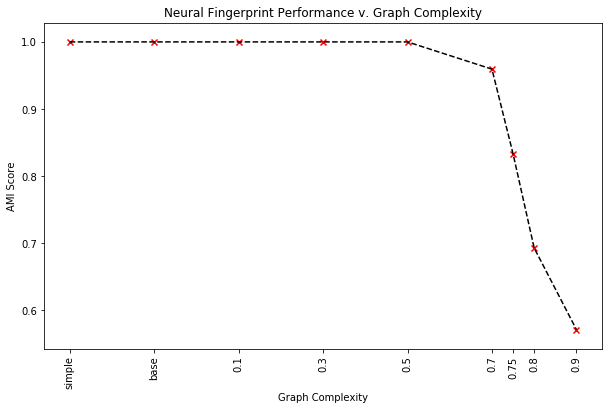

In [95]:
plt.rcParams['figure.figsize'] = (10, 6)

labels = ["simple", "base", "0.1", "0.3", "0.5", "0.7", "0.75", "0.8", "0.9"]
x = [1, 2, 3, 4, 5, 6, 6.25, 6.5, 7]
AMI_scores = [1,1,1,1,1,0.95938369500356069,0.8330724865976874,
              0.6925782213919377,0.57093115357219149]

fig, ax = plt.subplots(1,1) 
ax.scatter(x, AMI_scores, marker='x', c='r')
ax.plot(x, AMI_scores, linestyle='--', c='k')

ax.set_title("Neural Fingerprint Performance v. Graph Complexity")
ax.set_xlabel("Graph Complexity");
ax.set_ylabel("AMI Score");

ax.set_xticks(x);
ax.set_xticklabels(labels, rotation='vertical', fontsize=10);